## Reading and editing an image


In [1]:
import sys
import os
import glob
import re

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
matplotlib.rcParams["savefig.directory"] = ""
import matplotlib.pyplot as plt

from skimage import data, io, filters
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

from skimage.filters import threshold_minimum
from skimage.filters import threshold_local
from skimage.filters import threshold_otsu
#from skimage.filters import threshold_multiotsu

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import binary_closing
from skimage.morphology import disk
from skimage.morphology import remove_small_objects

from skimage import measure

In [2]:
fname = "img_1.png"
# fname = fname.split('\n')[0] # only if the filename contains '\n' at the end
print(fname)

img_1.png


In [3]:
# load the image
img_original = io.imread(fname)

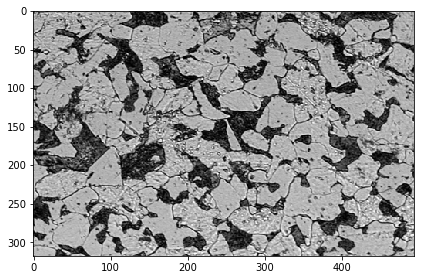

In [4]:
# display the image
io.imshow(img_original)

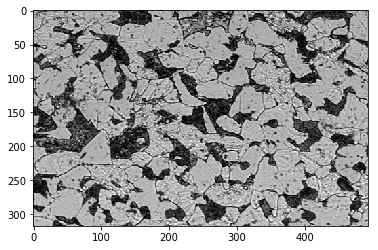

In [5]:
# display the image using matplotlib's plt
plt.imshow(img_original)

If one wants to view the image interactively with options for zooming etc., use the `%matplotlib notebook` environment

<IPython.core.display.Javascript object>


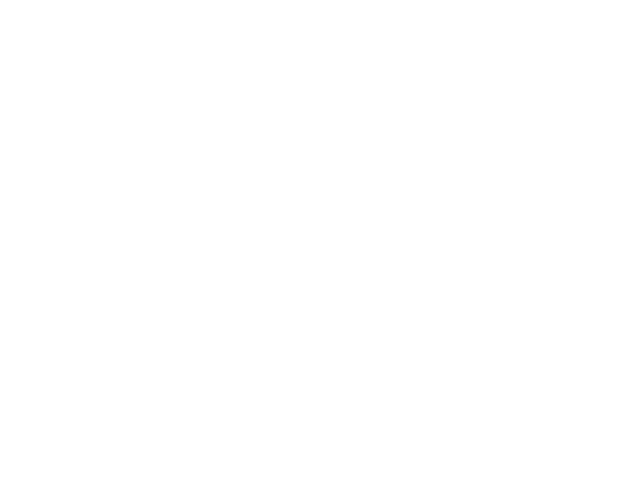

In [6]:
%matplotlib notebook
io.imshow(img_original)

To switch back to the `inline` environment use `%matplotlib inline`

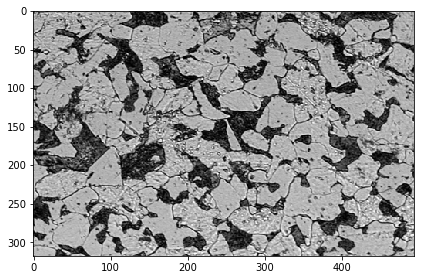

In [7]:
%matplotlib inline
io.imshow(img_original)

The image can be saved with the download image button in the interactive environment. To save the image using code...

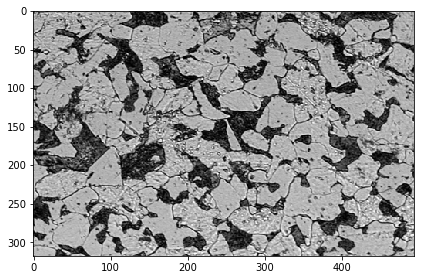

In [8]:
fname_save = 'img_1_color_dpi_300.png' # append the file extension to the file name, it can also be .jpg, .tif etc.
io.imshow(img_original)
plt.savefig(fname_save, dpi=300) # the dpi argument specifies the resolution of the image

In [9]:
# examine the type of the data structure in which the image is stored
type(img_original)

numpy.ndarray

The data structure of the image is `numpy.ndarray`. Now examine the size and shape of the image. This will give an idea about the image format, like is it RGB or only grayscale.

In [10]:
np.shape(img_original)

(318, 494, 3)

The shape of the image is `(318, 494, 3)`, where the last dimension 3 represents that the image has 3 channels represented by RGB colors. 318X494 is the size of the image in pixels.

In summary, all images are saved as arrays of size heightXwidthXchannels.

For further processing, we need to convert the image to black and white, i.e. remove the 3 color channels. This is done by the function rgb2gray().

In [11]:
X = rgb2gray(img_original)
np.shape(X)

(318, 494)

## Grayscale to Binary image
We can also make this image from gray scale to binary (i.e. only black and white (BW)). This BW image is useful in applying certain filters and image processing algorithms. Thresholding (conversion of grayscale to BW image) is done in the following ways:

### Manual threshold
The threshold value is manually set by trial and error. White represents 1, and black represents 0. Set a value of `thresh_manual` between 0 and 1. Higher value of `thresh_manual` results in blacker images.

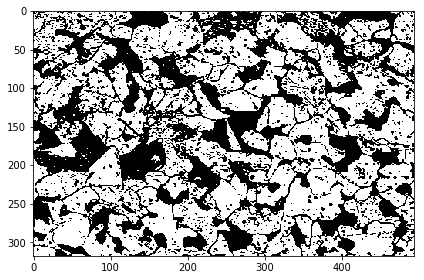

In [12]:
thresh_manual = 0.6
binary_X = X > thresh_manual
io.imshow(binary_X)

### Automatic Threshold
The threshold value is automatically set by using the Otsu algorithm. It statistically segments the image into black and white regions by looking at the histogram of the pixel values.

In [13]:
thresh_otsu = threshold_otsu(X) # remember we have imported threshold_otsu() function at the beginning of the code
display(thresh_otsu) # prints the value of thresh_otsu

0.439453125

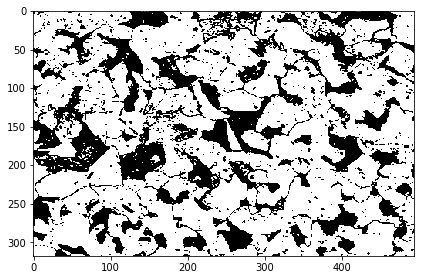

In [14]:
# use thresh_otsu to convert to binary
binary_X = X > thresh_otsu
io.imshow(binary_X)

### Adaptive Threshold
This threshold value is automatically generated **locally** based upon the local conditions. Unlike Otsu there is no single threshold value for the entire image. It is beneficial when the image has changing brightness value across different regions of the image. The size of the local region to be considered is given in `block_size` in pixels.

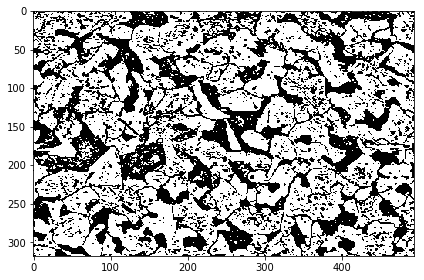

In [15]:
thresh_local = threshold_local(X, block_size=49)
# use thresh_local to convert to binary
binary_X = X > thresh_local
io.imshow(binary_X)

## Remove small noise areas (connected components)
From using different thresholding algorithms, we see that for this particular image Otsu gives the best results, i.e. it is able to separrate the pearlite (black+white) phase from the austenite (white phase). In order to find the amount of pearlite in the microstructure, we further have to clean the image. Here, we first remove specks of white dots in the black phase and then remove specks of black dots from the white phase. 

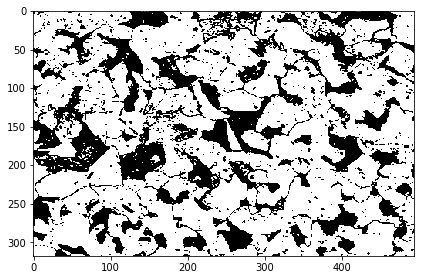

In [16]:
# use thresh_otsu to convert to binary
binary_X = X > thresh_otsu
io.imshow(binary_X)

### Remove white specks from black phase

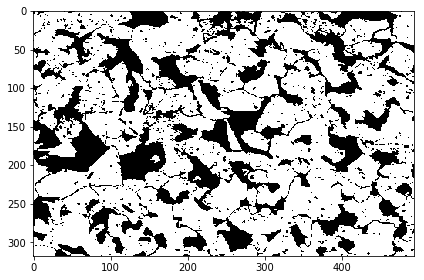

In [17]:
binary_rm = remove_small_objects(binary_X, min_size=28)
io.imshow(binary_rm)

### Remove black specks from white phase

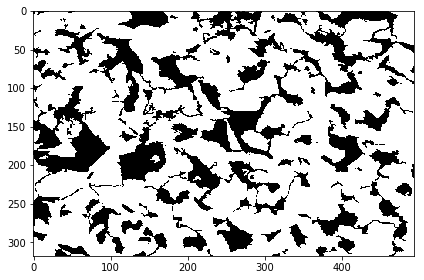

In [18]:
binary_rm_2 = ~remove_small_objects(~binary_rm, min_size=20) # we are taking complements of the image, 
# because the algorithm is only designed to remove whie foreground on black background, 
# and here we are doing the reverse.
io.imshow(binary_rm_2)

## Obtaining statistics: Area fraction
Now the image is cleaned, we can obtain some statistics like the approximate phase fraction.

In [19]:
img_area = np.shape(binary_rm_2)[0]*np.shape(binary_rm_2)[1]
area_fraction = np.sum(binary_rm_2)/img_area
print("area fraction of white phase = ", area_fraction)

area fraction of white phase =  0.7189735950907749


## Number and distribution of black phase

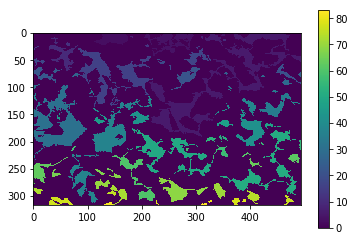

In [20]:
image_labels, count_labels = measure.label(~binary_rm_2, background=0, return_num=True)
plt.imshow(image_labels)
plt.colorbar()
plt.show()

properties = measure.regionprops(image_labels)
areas = [prop.area for prop in properties]
perimeters = [prop.perimeter for prop in properties]

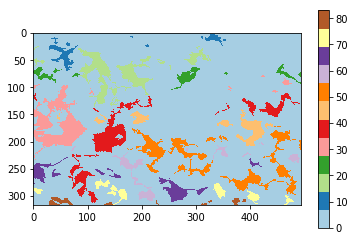

In [21]:
image_labels_thresholded = np.copy(image_labels)
# image_labels_thresholded[image_labels == 0.0] = np.nan
cmap_c=plt.get_cmap('Paired')
cmap_c.set_bad(color='black')
plt.imshow(image_labels_thresholded, cmap=cmap_c)
plt.colorbar()